In [ ]:
# To predict the overall rating of soccer player based on their attributes such as 'crossing', 'finishing etc.

In [4]:
# Import Libraries

import sqlite3
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Create your connection.
cnx = sqlite3.connect('C:/Users/amit22213/Desktop/Acadgild/Study Material/23. Project-2/database.sqlite')

In [6]:
Player_Attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
Player_Attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [7]:
tables = pd.read_sql("""SELECT * FROM sqlite_master
                        WHERE type='table';""", cnx)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [8]:
# List of countries
countries = pd.read_sql("""SELECT * FROM Country;""", cnx)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [9]:
# List of leagues and their country 
leagues = pd.read_sql("""SELECT * FROM League
                        JOIN Country ON Country.id = League.country_id;""", cnx)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [10]:
# List of teams
teams = pd.read_sql("""SELECT * FROM Team
                        ORDER BY team_long_name
                        LIMIT 10;""", cnx)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


In [11]:
# List of matches
detailed_matches = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER by date
                                LIMIT 10;""", cnx)
detailed_matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0
5,21522,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Racing Santander,Sevilla FC,1,1
6,21523,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Sporting de Gijón,Getafe CF,1,2
7,21524,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Betis Balompié,RC Recreativo,0,1
8,21526,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Athletic Club de Bilbao,UD Almería,1,3
9,21527,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Atlético Madrid,Málaga CF,4,0


In [12]:
# Leagues by season
leages_by_season = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY Country.name, League.name, season DESC
                                ;""", cnx)
leages_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


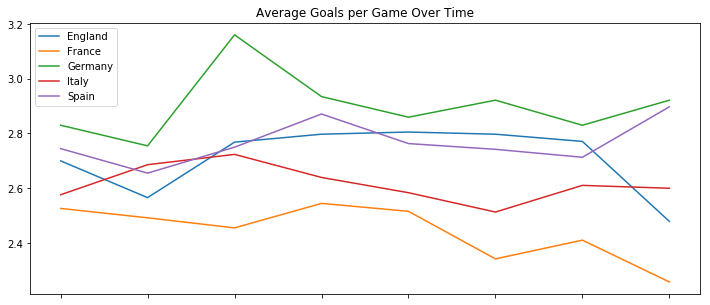

In [13]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time')

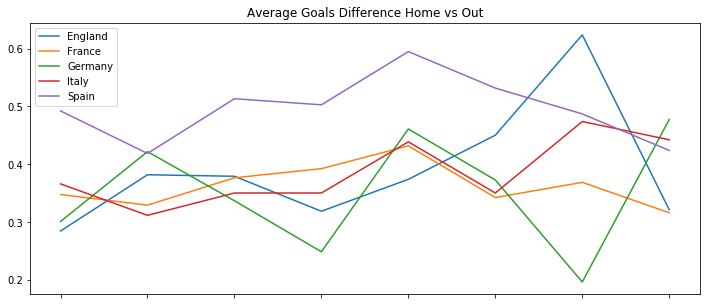

In [14]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])

df.plot(figsize=(12,5),title='Average Goals Difference Home vs Out')

In [15]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height, 
                                        COUNT(height) AS distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight 
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential  
                                        FROM Player_Attributes
                                        GROUP BY Player_Attributes.player_api_id) 
                                        AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", cnx)
players_height

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


In [16]:
Player_Attributes.shape

(183978, 42)

In [34]:
Player_Attributes.dropna(inplace=True)
Player_Attributes.shape

(180354, 43)

In [35]:
# Compute the correlation matrix
corr = Player_Attributes.corr()

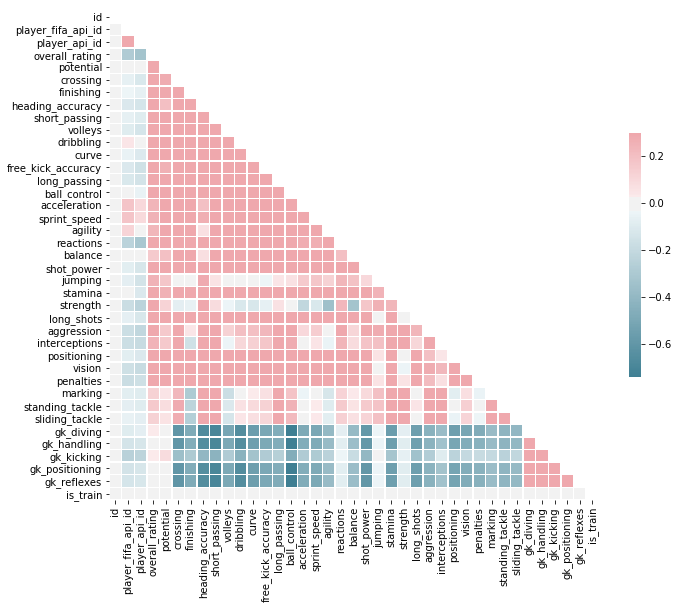

In [36]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
# Add a column that tells us if it's Training Data or not
Player_Attributes['is_train'] = np.random.uniform(0, 1, len(Player_Attributes)) <= .75

In [38]:
# Divide between training and testing data
train, test = Player_Attributes[Player_Attributes['is_train'] == True],Player_Attributes[Player_Attributes['is_train'] == False]

In [39]:
train.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,is_train
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,True
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,True
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,True
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,True
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,True


In [40]:
test.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,is_train
12,13,189615,155782,2015-09-21 00:00:00,73.0,77.0,left,medium,medium,79.0,...,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,False
13,14,189615,155782,2015-01-09 00:00:00,71.0,75.0,left,medium,medium,78.0,...,58.0,73.0,72.0,72.0,13.0,6.0,8.0,8.0,11.0,False
15,16,189615,155782,2014-11-07 00:00:00,71.0,77.0,left,medium,medium,78.0,...,58.0,73.0,72.0,72.0,13.0,6.0,8.0,8.0,11.0,False
16,17,189615,155782,2014-09-18 00:00:00,70.0,77.0,left,medium,medium,77.0,...,58.0,73.0,72.0,72.0,13.0,6.0,8.0,8.0,11.0,False
36,37,189615,155782,2008-08-30 00:00:00,53.0,60.0,right,medium,medium,22.0,...,29.0,53.0,45.0,63.0,6.0,22.0,49.0,22.0,22.0,False


In [41]:
# We choose the columns with player stats
features = Player_Attributes.columns[9:]
# Split into Training X(stats) and Y(rating) data
X = train[features]
Y = train.loc[:,'overall_rating']

In [42]:
X.head()

,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,is_train
0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,True
1,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,True
2,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,True
3,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,True
4,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,True


In [43]:
Y.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

In [44]:
# Initialize the Classifier and train it

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=4)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
# Get the predictions
preds = clf.predict(test[features])

In [47]:
# Create an output dataframe
out = test.loc[:,['player_fifa_api_id','player_api_id','overall_rating']]
out['prediction'] = preds
out['diff']=out.loc[:,'overall_rating']-out.loc[:,'prediction']

In [48]:
# Let's print mean difference between predicted and actual
print('Mean difference: ',out['diff'].mean())

Mean difference:  0.12234895740509713


In [50]:
# And the number of exact matches
print('Exact Matches:',len(out[out['diff']==0]))

Exact Matches: 30817


In [51]:
#Let's print the players with rating and prediction
print(out.loc[:,['player_fifa_api_id','player_api_id','overall_rating','prediction','diff']])

        player_fifa_api_id  player_api_id  overall_rating  prediction  diff
12                  189615         155782            73.0        73.0   0.0
13                  189615         155782            71.0        71.0   0.0
15                  189615         155782            71.0        71.0   0.0
16                  189615         155782            70.0        70.0   0.0
36                  189615         155782            53.0        53.0   0.0
42                  186170         162549            68.0        68.0   0.0
46                  186170         162549            70.0        69.0   1.0
50                  186170         162549            70.0        70.0   0.0
53                  186170         162549            69.0        69.0   0.0
55                  186170         162549            65.0        62.0   3.0
57                  186170         162549            65.0        65.0   0.0
59                  186170         162549            67.0        67.0   0.0
61          